## 사전 준비 (이미 수행했다면 Skip)
아래 스크립트를 실행

- Covid19-Pneumonia-3-categories-classification DataSet 다운로드
- DataSet을 Minio에 업로드
- Minio에 model 저장용 Butket 생성

# Covid19-Pneumonia-3-categories-classification

In [1]:
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers, models, layers
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50V2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import io
from PIL import Image

from minio import Minio
from minio.error import ResponseError

# Data Preparation

In [2]:
print("Loading images...")

minioClient = Minio(
                'minio-service.kubeflow:9000',
                access_key='minio', 
                secret_key='minio123', 
                secure=False
            )

data = []
labels = []
Testdata = []
Testlabels = []

# read all X-Rays in the specified path, and resize them all to 256x256

for i in minioClient.list_objects('dataset', prefix='covid-19', recursive=True):
    label = i.object_name.split(os.path.sep)[-2]
    usage = i.object_name.split(os.path.sep)[-3]
    minioObj = minioClient.get_object('dataset', i.object_name)
    byteArray = minioObj.read()
    pil_image = Image.open(io.BytesIO(byteArray)).convert('RGB')
    image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    image = cv2.resize(image, (256, 256))
    if usage == 'train':
        data.append(image)
        labels.append(label)
    else :
        Testdata.append(image)
        Testlabels.append(label)
        

Loading images...


In [3]:
#normalise pixel values to real numbers between 0.0 - 1.0 
data = np.array(data) / 255.0
labels = np.array(labels)

In [4]:
# perform one-hot encoding for a 3-class labeling 
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
labels = to_categorical(integer_encoded)

print("... ... ", len(data), "images loaded in 3x classes:")
print(label_encoder.classes_)

... ...  200 images loaded in 3x classes:
['covid' 'normal' 'pneumonia_bac']


In [5]:
(x_train, x_val, y_train, y_val) = train_test_split(data, labels, test_size=0.20, stratify=labels)
x_train.shape, x_val.shape, y_train.shape

((160, 256, 256, 3), (40, 256, 256, 3), (160, 3))

# Model 구성

In [6]:
# Hyperparameters 
LEARNING_RATE = 0.00001 # List: 0.001, 0.0001, 0.0003, 0.00001, 0.00003
DENSE = 128             # Range: 50-200

In [7]:
model = Sequential()
adam_s = Adam(learning_rate = LEARNING_RATE)

#model.add(VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='average'))
model.add(ResNet50V2(input_shape=(256, 256, 3),include_top=False, weights='imagenet',pooling='average'))

for layer in model.layers:
    layer.trainable = False

model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(DENSE, activation='relu'))
model.add(Dense(DENSE, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=adam_s, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 8, 8, 2048)        23564800  
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               16777344  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 40,367,235
Trainable params: 16,798,339
Non-trainable params: 23,568,896
___________________________________

# Model 학습

In [8]:
# train the head of the network
print("Training the full stack model...")
# hist = model.fit(x_train, y_train, epochs=40, validation_data=(x_val, y_val), batch_size=8)
hist = model.fit(x_train, y_train, epochs=3, validation_data=(x_val, y_val), batch_size=8)

Training the full stack model...
Train on 160 samples, validate on 40 samples
Epoch 1/3
160/160 [==============================] - 53s 328ms/sample - loss: 0.9773 - accuracy: 0.5500 - val_loss: 1.7325 - val_accuracy: 0.4000
Epoch 2/3
160/160 [==============================] - 49s 304ms/sample - loss: 0.3334 - accuracy: 0.9375 - val_loss: 1.4780 - val_accuracy: 0.4500
Epoch 3/3
160/160 [==============================] - 48s 301ms/sample - loss: 0.1323 - accuracy: 0.9937 - val_loss: 1.3235 - val_accuracy: 0.5250


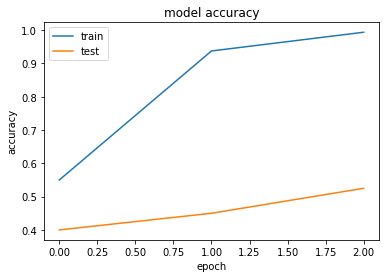

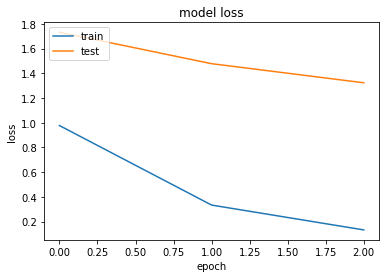

In [9]:
## summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
loss         = hist.history['loss']
accuracy     = hist.history['accuracy']
val_loss     = hist.history['val_loss']
val_accuracy = hist.history['val_accuracy']

##print(loss        )
print(accuracy[-1]    )
##print(val_loss    )
print(val_accuracy[-1])

0.99375
0.525


# Model 평가

In [11]:
#normalise pixel values to real numbers between 0.0 - 1.0 
Testdata_n = np.array(Testdata) / 255.0
Testlabels_n = np.array(Testlabels)

# perform one-hot encoding for a 3-class labeling 
label_encoder = LabelEncoder()
Testinteger_encoded = label_encoder.fit_transform(Testlabels_n)
Testlabels_c = to_categorical(Testinteger_encoded)

x_test = Testdata_n
y_test = Testlabels_c
x_test.shape, y_test.shape

((27, 256, 256, 3), (27, 3))

In [12]:
#model = models.load_model("s3://model/new-covid/1/saved_model.pb")
eval = model.evaluate(x_test, y_test)

27/27 [==============================] - 6s 234ms/sample - loss: 1.2936 - accuracy: 0.4074


In [13]:
print("test loss, test acc:", eval)

test loss, test acc: [1.2935701608657837, 0.4074074]


# Serving Test용 input json 생성

In [14]:
import json

#get some sample data
sample_test_data = x_test[2]  #[0:2]
sample_test_labels = y_test[2] #[0:2]

class_names = ['covid', 'normal', 'pneumonia_bac']

# pre-process data 
#sample_test_data_processed = np.expand_dims(sample_test_data / 255., axis=3)

sample_test_data = np.expand_dims(sample_test_data, axis=0)
print(sample_test_data.shape)

sample_test_data_processed = sample_test_data

# create payload
data = json.dumps({"signature_name": "serving_default", 
                   "instances": sample_test_data_processed.tolist()})

#with open("image_data.json", "w") as json_file:
#    json.dump(data, json_file)
with open("image_data.json", "w") as text_file:
    text_file.write("%s" % data)

(1, 256, 256, 3)


In [15]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)

cm = confusion_matrix(y_test.argmax(axis=1), pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
specificity = (cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2]) / (cm[1, 0] + cm[1, 1] + cm[1, 2] + cm[2, 0] + cm[2, 1] + cm[2, 2])

print(cm)
print(" ")
print("accuracy: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[0 0 9]
 [0 2 7]
 [0 0 9]]
 
accuracy: 0.4074
sensitivity: 0.0000
specificity: 1.0000


# Model 저장

In [16]:
os.environ.update({
    'S3_ENDPOINT'          : 'minio-service.kubeflow:9000',
    'AWS_ACCESS_KEY_ID'    : 'minio',
    'AWS_SECRET_ACCESS_KEY': 'minio123',
    'S3_USE_HTTPS'         : '0',   # Whether or not to use HTTPS. Disable with 0.                        
    'S3_VERIFY_SSL'        : '0'    # If HTTPS is used, controls if SSL should be enabled. Disable with 0.
})  

model.save("s3://saved-model/covid-19/1")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: s3://saved-model/covid-19/1/assets
